In [473]:
%matplotlib inline

In [474]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 200

In [2]:
import os
from functools import partial

from celerite import plot_setup
plot_setup.setup(auto=False)

from pylab import *
from pandas import DataFrame

import batman
import emcee3, corner
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

from astropy.io import fits
from glob import glob

from tqdm import tqdm_notebook
emcee3.samplers.tqdm_notebook = tqdm_notebook

from scipy.optimize    import leastsq, minimize
from scipy.interpolate import CubicSpline
from scipy.signal      import medfilt
from scipy.stats       import binned_statistic

from lmfit import Model, Parameters

from statsmodels.robust import scale
mad = scale.mad

from time import time

from sys import argv

from photutils import CircularAperture, CircularAnnulus, EllipticalAperture
from photutils import aperture_photometry

from statsmodels.robust import scale
from datetime import datetime

import jdcal
import datetime

from exoparams import PlanetParams

from numpy import cos, pi, abs

from sklearn.svm import SVR
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import StandardScaler

from multiprocessing import cpu_count, Pool

import spiderman as sp
from astropy.constants import R_sun, au

from ExoplanetTSO_Auxiliary import wanderer

from spitzer_helper_functions import clipOutliers, bin_array, b2inc, deltaphase_eclipse#, batman_lmfit_model, spiderman_lmfit_model
from spitzer_helper_functions import extract_PLD_components, de_median, savePickleOut
from spitzer_helper_functions import phase_cos_curve, phase_cos_sin_curve, inc2b

stdScaler = StandardScaler()
stime = time()

looking for spidermanrc file at /Users/jonathan/.spidermanrc
no spidermanrc file detected


In [476]:
print("\n**DONE LOADING LIBRARIES AND DEFINING FUNCTIONS**\n")


**DONE LOADING LIBRARIES AND DEFINING FUNCTIONS**



# List of Function Definitions

In [477]:
def batman_lmfit_model(period, tCenter, inc, aprs, edepth, tdepth, ecc, omega, times, u1=None, u2=None,
                       ldtype = 'uniform', transittype="primary", bm_params=None):
    
    if tdepth is not 0.0 or edepth is not 0.0:
        if bm_params is None:
            bm_params = batman.TransitParams() # object to store transit parameters
        
        bm_params.per       = period  # orbital period
        bm_params.t0        = tCenter # time of inferior conjunction
        bm_params.a         = aprs    # semi-major axis (in units of stellar radii)
        bm_params.fp        = edepth  # f
        bm_params.tdepth    = tdepth  # from Fraine et al. 2014s
        bm_params.rp        = sqrt(tdepth) # planet radius (in units of stellar radii)
        bm_params.ecc       = ecc     # eccentricity
        bm_params.w         = omega   # longitude of periastron (in degrees)
        bm_params.inc       = inc     # orbital inclination (in degrees)
        bm_params.limb_dark = ldtype  # limb darkening model # NEED TO FIX THIS
        bm_params.u         = []      # limb darkening coefficients # NEED TO FIX THIS
        
        if u1 is not None and ldtype is not 'uniform':
            bm_params.u.append(u1)
        elif u1 is not None and ldtype is 'uniform':
            raise ValueError('If you set `u1`, you must also set `ldtype` to either linear or quadratic')
        if u2 is not None and ldtype is 'quadratic':
            bm_params.u.append(u2)
        elif u2 is not None and ldtype is not 'quadratic':
            raise ValueError('If you set `u2`, you must also set `ldtype` quadratic')
        
        bm_params.delta_phase = deltaphase_eclipse(bm_params.ecc, bm_params.w)
        bm_params.t_secondary = bm_params.t0 + bm_params.per*bm_params.delta_phase
        
        m_eclipse = batman.TransitModel(bm_params, times, transittype=transittype).light_curve(bm_params)
    else:
        return ones(times.size)
    
    return m_eclipse

In [478]:
def spiderman_lmfit_model(period, tCenter, inc, aprs, tdepth, ecc, omega, times, u1, u2, xi, T_night, delta_T, 
                         nspiders=1000, nCores = cpu_count()):
                          # spider_params=None, n_layers=20, stellar_radius = 1.0, stellar_temperature=5500.,
                          # wave_low = 4.0, wave_hi = 5.0, brightness_model='zhang'):
    
    if tdepth is not 0.0:
        # if False:# and spider_params is None:
        #     spider_params                = sp.ModelParams(brightness_model=brightness_model)
        #     spider_params.n_layers       = n_layers
        #     spider_params.stellar_radius = stellar_radius
        #     spider_params.T_s            = stellar_temperature
        #     spider_params.l1             = wave_low
        #     spider_params.l2             = wave_hi
        
        a_au  = aprs * spider_params.stellar_radius * R_sun.value / au.value
        # inc   = b2inc(bImpact, aprs, ecc, omega)*180/pi
        
        spider_params.t0      = tCenter      # Central time of PRIMARY transit [days]
        spider_params.per     = period       # Period [days]
        spider_params.a_abs   = a_au         # The absolute value of the semi-major axis [AU]
        spider_params.inc     = inc # orbital inclination (in degrees)
        spider_params.ecc     = ecc          # Eccentricity
        spider_params.w       = omega        # Argument of periastron
        spider_params.rp      = sqrt(tdepth) # planet radius (in units of stellar radii)
        spider_params.a       = aprs         # Semi-major axis scaled by stellar radius
        spider_params.p_u1    = u1           # Planetary limb darkening parameter
        spider_params.p_u2    = u2           # Planetary limb darkening parameter
        
        spider_params.xi      = xi           # Ratio of radiative to advective timescale             
        spider_params.T_n     = T_night      # Temperature of nightside
        spider_params.delta_T = delta_T      # Day-night temperature contrast
        
        nskips            = times.size // nspiders
        times_subsampled  = times[::nskips]
        spider_lightcurve = spider_params.lightcurve(times_subsampled)
        spider_lightcurve = CubicSpline(times_subsampled, spider_lightcurve)
        
        return spider_lightcurve(times)
        
        # pool = Pool(nCores)

        # func = partial(spider_params.lightcurve)

        # spider_lightcurve = pool.starmap(func, zip(times))

        # pool.close()
        # pool.join()

        # return np.array(spider_lightcurve)
    else:
        return ones(times.size)
    
    raise Exception('Something Weird happened')

In [479]:
def spiderman_half_phase_curve_lmfit_model(times, PLDFeatures, #flux,
                                         period, tCenter, inc, aprs, edepth, tdepth, ecc, omega, 
                                         u1, u2, xi, T_night, delta_T, # mean, 
                                         pld1_l, pld2_l, pld3_l, pld4_l, pld5_l, pld6_l, pld7_l, pld8_l, pld9_l,
                                         pld1_q, pld2_q, pld3_q, pld4_q, pld5_q, pld6_q, pld7_q, pld8_q, pld9_q,
                                         intcpt=1.0, slope=0.0, crvtur=0.0):#, spider_params=None):
    
    PLDCoeffs   = [pld1_l, pld2_l, pld3_l, pld4_l, pld5_l, pld6_l, pld7_l, pld8_l, pld9_l, \
                   pld1_q, pld2_q, pld3_q, pld4_q, pld5_q, pld6_q, pld7_q, pld8_q, pld9_q]
    
    instrumental  = intcpt*np.ones(times.size)
    if slope != 0.0:
        instrumental += slope*(times-times.mean())
    if crvtur != 0.0:
        instrumental += crvtur*(times-times.mean())**2.
    
    if PLDFeatures.shape[1] > len(PLDCoeffs):
        print("Something is weird in the `fourier_half_phase_curve_lmfit_model` because you have more than 9 \
                            PLD Features and I don't know what to do with lucky number 10." )
        raise Exception()
    
    instrumental += dot(PLDFeatures, PLDCoeffs) # This is now quadratic
    
    spider_model  = partial(spiderman_lmfit_model, period=period, tCenter=tCenter, inc=inc, aprs=aprs, 
                                       tdepth=tdepth, ecc=ecc, omega=omega, times=times, u1=u1, u2=u2)
    
    phase_curve   = spider_model(xi=xi, T_night=T_night, delta_T=delta_T)
    
    batman_model  = partial(batman_lmfit_model, period=period, tCenter=tCenter, inc=inc, aprs=aprs, 
                                       times=times, edepth=edepth, tdepth=tdepth, ecc=ecc, omega=omega)
    
    transit       = batman_model(transittype="primary"  , u1=u1, u2=u2, ldtype='quadratic')
    
    return instrumental * transit * phase_curve

In [480]:
def spiderman_full_phase_curve_lmfit_model(times_0, times_1, PLDFeatures_0, PLDFeatures_1, #flux,
                         period, tCenter, inc, aprs, edepth, tdepth, ecc, omega, #bImpact
                         u1, u2, xi, T_night, delta_T, # mean, 
                         pld1_l_1, pld2_l_1, pld3_l_1, pld4_l_1, pld5_l_1, pld6_l_1, pld7_l_1, pld8_l_1, pld9_l_1,
                         pld1_q_1, pld2_q_1, pld3_q_1, pld4_q_1, pld5_q_1, pld6_q_1, pld7_q_1, pld8_q_1, pld9_q_1,
                         pld1_l_2, pld2_l_2, pld3_l_2, pld4_l_2, pld5_l_2, pld6_l_2, pld7_l_2, pld8_l_2, pld9_l_2,
                         pld1_q_2, pld2_q_2, pld3_q_2, pld4_q_2, pld5_q_2, pld6_q_2, pld7_q_2, pld8_q_2, pld9_q_2,
                         intcpt=1.0, slope=0.0, crvtur=0.0):
    
    PLDCoeffs_0 = [pld1_l_1, pld2_l_1, pld3_l_1, pld4_l_1, pld5_l_1, pld6_l_1, pld7_l_1, pld8_l_1, pld9_l_1, \
                   pld1_q_1, pld2_q_1, pld3_q_1, pld4_q_1, pld5_q_1, pld6_q_1, pld7_q_1, pld8_q_1, pld9_q_1]
    
    PLDCoeffs_1 = [pld1_l_2, pld2_l_2, pld3_l_2, pld4_l_2, pld5_l_2, pld6_l_2, pld7_l_2, pld8_l_2, pld9_l_2, \
                   pld1_q_2, pld2_q_2, pld3_q_2, pld4_q_2, pld5_q_2, pld6_q_2, pld7_q_2, pld8_q_2, pld9_q_2]
    
    times_c     = np.c_[[times_0], [times_1]].flatten()
    
    instrumental  = intcpt*np.ones(times_c.size)
    if slope != 0.0:
        instrumental += slope*(times_c-times_c.mean())
    if crvtur != 0.0:
        instrumental += crvtur*(times_c-times_c.mean())**2.
    
    if PLDFeatures_0.shape[1] > len(PLDCoeffs_0):
        print("Something is weird in the `fourier_half_phase_curve_lmfit_model` because you have more than {} \
        PLD Features and I don't know what to do with lucky number {}.".format(len(PLDCoeffs_0), len(PLDCoeffs_0)+1))
        raise Exception()
    
    if PLDFeatures_1.shape[1] > len(PLDCoeffs_1):
        print("Something is weird in the `fourier_half_phase_curve_lmfit_model` because you have more than {} \
        PLD Features and I don't know what to do with lucky number {}.".format(len(PLDCoeffs_1), len(PLDCoeffs_1)+1))
        raise Exception()
    
    pld_0 = dot(PLDFeatures_0, PLDCoeffs_0) # This is now quadratic
    pld_1 = dot(PLDFeatures_1, PLDCoeffs_1) # This is now quadratic
    
    instrumental += np.c_[[pld_0], [pld_1]].flatten()
    
    # inc   = b2inc(bImpact, aprs)*180/pi
    
    spider_model  = partial(spiderman_lmfit_model, period=period, tCenter=tCenter, inc=inc, aprs=aprs, 
                                       tdepth=tdepth, ecc=ecc, omega=omega, times=times_c, u1=u1, u2=u2)
    
    batman_model  = partial(batman_lmfit_model, period=period, tCenter=tCenter, inc=inc, aprs=aprs, 
                                       times=times_c, edepth=edepth, tdepth=tdepth, ecc=ecc, omega=omega)
    
    phase_curve   = spider_model(xi=xi, T_night=T_night, delta_T=delta_T)
    
    transit       = batman_model(transittype="primary"  , u1=u1, u2=u2, ldtype='quadratic')
    
    return instrumental * transit * phase_curve

In [3]:
np.reshape

In [481]:
def plot_model_over_reduced_lc_half_spider_PLDsq(times, PLDFeatures, fitResults, figsize=None, nbins=200, plotRawData=False):
    
    fit_values  = fitResults.best_values
    phots       = fitResults.data
    phots_err   = fitResults.weights
    
    PLDCoeffs   = [fit_values['pld1_l'], 
                   fit_values['pld2_l'], 
                   fit_values['pld3_l'], 
                   fit_values['pld4_l'], 
                   fit_values['pld5_l'], 
                   fit_values['pld6_l'], 
                   fit_values['pld7_l'], 
                   fit_values['pld8_l'], 
                   fit_values['pld9_l'],
                   fit_values['pld1_q'], 
                   fit_values['pld2_q'], 
                   fit_values['pld3_q'], 
                   fit_values['pld4_q'], 
                   fit_values['pld5_q'], 
                   fit_values['pld6_q'], 
                   fit_values['pld7_q'], 
                   fit_values['pld8_q'], 
                   fit_values['pld9_q']]
    
    instrumental = fitResults.best_values['intcpt']*np.ones(times.size)
    if 'slope' in fitResults.best_values.keys() and fitResults.best_values['slope'] != 0.0:
        instrumental += fitResults.best_values['slope']*(times - times.mean())
    if 'crvtur' in fitResults.best_values.keys() and fitResults.best_values['crvtur'] != 0.0:
        instrumental += fitResults.best_values['crvtur']*(times - times.mean())**2.
    
    instrumental  += dot(PLDFeatures,PLDCoeffs)
    
    period  = fit_values['period']
    tCenter = fit_values['tCenter']
    inc     = fit_values['inc']
    aprs    = fit_values['aprs']
    edepth  = fit_values['edepth']
    tdepth  = fit_values['tdepth']
    ecc     = fit_values['ecc']
    omega   = fit_values['omega']
    u1      = fit_values['u1']
    u2      = fit_values['u2']
    # mean    = fit_values['mean']
    
    spider_model  = partial(spiderman_lmfit_model, period=period, tCenter=tCenter, inc=inc, aprs=aprs, 
                                       tdepth=tdepth, ecc=ecc, omega=omega, times=times, u1=u1, u2=u2)
    
    batman_model  = partial(batman_lmfit_model, period=period, tCenter=tCenter, inc=inc, aprs=aprs, 
                                       times=times, edepth=edepth, tdepth=tdepth, ecc=ecc, omega=omega)
            
    transit = batman_model(u1=u1, u2=u2, ldtype='quadratic', transittype="primary")
    
    xi      = fit_values['xi']
    T_night = fit_values['T_night']
    delta_T = fit_values['delta_T']
    
    phase_curve   = spider_model(xi=xi, T_night=T_night, delta_T=delta_T) # + mean
    
    # edepth  = spider_params.eclipse_depth()
    
    binsize = phots.size // nbins
    
    bin_flux    , _ = bin_array(phots.values/instrumental, binsize=binsize)
    bin_flux_err, _ = bin_array(phots_err.values         , binsize=binsize)
    bin_time    , _ = bin_array(times.values             , binsize=binsize)
    
    bin_flux_err= bin_flux_err/sqrt(bin_flux_err.size)
    
    fig= figure() if figsize is None else figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    if plotRawData:
        ax.plot(times, phots/ instrumental, '.', ms=1, label='data')
    
    ax.errorbar(bin_time, bin_flux, bin_flux_err, fmt='o', label='binned data', ms=1, zorder=1, lw=1)
    ax.plot(times, transit * phase_curve, 'violet', lw=2,label='best fit model', zorder=0)
    # ax.plot(times, phase_curve, 'orange', lw=2,label='spiderman model')
    # ax.set_title('Eclipse depth = {} ppm'.format(np.int(edepth*1e6)))
    ax.legend(loc=0)

In [514]:
def plot_model_over_reduced_full_lc_spider_PLDsq(times_0      , times_1      , 
                                            PLDFeatures_0, PLDFeatures_1, 
                                            fitResults   , figsize=None , 
                                            nbins=200    , plotRawData=False):
    
    fit_values  = fitResults.best_values
    phots       = fitResults.data
    phots_err   = 1/fitResults.weights
    
    PLDCoeffs_0 = [fit_values['pld1_l_1'], 
                   fit_values['pld2_l_1'], 
                   fit_values['pld3_l_1'], 
                   fit_values['pld4_l_1'], 
                   fit_values['pld5_l_1'], 
                   fit_values['pld6_l_1'], 
                   fit_values['pld7_l_1'], 
                   fit_values['pld8_l_1'], 
                   fit_values['pld9_l_1'],
                   fit_values['pld1_q_1'], 
                   fit_values['pld2_q_1'], 
                   fit_values['pld3_q_1'], 
                   fit_values['pld4_q_1'], 
                   fit_values['pld5_q_1'], 
                   fit_values['pld6_q_1'], 
                   fit_values['pld7_q_1'], 
                   fit_values['pld8_q_1'], 
                   fit_values['pld9_q_1']]
    
    PLDCoeffs_1 = [fit_values['pld1_l_2'], 
                   fit_values['pld2_l_2'], 
                   fit_values['pld3_l_2'], 
                   fit_values['pld4_l_2'], 
                   fit_values['pld5_l_2'], 
                   fit_values['pld6_l_2'], 
                   fit_values['pld7_l_2'], 
                   fit_values['pld8_l_2'], 
                   fit_values['pld9_l_2'],
                   fit_values['pld1_q_2'], 
                   fit_values['pld2_q_2'], 
                   fit_values['pld3_q_2'], 
                   fit_values['pld4_q_2'], 
                   fit_values['pld5_q_2'], 
                   fit_values['pld6_q_2'], 
                   fit_values['pld7_q_2'], 
                   fit_values['pld8_q_2'], 
                   fit_values['pld9_q_2']]
    
    times_c = np.c_[[times_0], [times_1]].flatten()
    
    instrumental = fitResults.best_values['intcpt']*np.ones(times_c.size)
    if 'slope' in fitResults.best_values.keys() and fitResults.best_values['slope'] != 0.0:
        instrumental += fitResults.best_values['slope']*(times_c - times_c.mean())
    if 'crvtur' in fitResults.best_values.keys() and fitResults.best_values['crvtur'] != 0.0:
        instrumental += fitResults.best_values['crvtur']*(times_c - times_c.mean())**2.
    
    pld_0   = dot(PLDFeatures_0, PLDCoeffs_0)
    pld_1   = dot(PLDFeatures_1, PLDCoeffs_1)
    
    instrumental += np.c_[[pld_0], [pld_1]].flatten()
    
    period  = fit_values['period']
    tCenter = fit_values['tCenter']
    # inc     = b2inc(fit_values['bImpact'], fit_values['aprs'])
    inc     = fit_values['inc']
    aprs    = fit_values['aprs']
    edepth  = fit_values['edepth']
    tdepth  = fit_values['tdepth']
    ecc     = fit_values['ecc']
    omega   = fit_values['omega']
    u1      = fit_values['u1']
    u2      = fit_values['u2']
    
    spider_model  = partial(spiderman_lmfit_model, period=period, tCenter=tCenter, inc=inc, aprs=aprs, 
                                       tdepth=tdepth, ecc=ecc, omega=omega, times=times_c, u1=u1, u2=u2)
    
    batman_model  = partial(batman_lmfit_model, period=period, tCenter=tCenter, inc=inc, aprs=aprs, 
                                       times=times_c, edepth=edepth, tdepth=tdepth, ecc=ecc, omega=omega)
    
    transit = batman_model(u1=u1, u2=u2, ldtype='quadratic', transittype="primary")
    
    xi      = fit_values['xi']
    T_night = fit_values['T_night']
    delta_T = fit_values['delta_T']
    
    phase_curve   = spider_model(xi=xi, T_night=T_night, delta_T=delta_T)
    
    binsize = phots.size // nbins
    
    bin_flux    , _ = bin_array(phots/instrumental, binsize=binsize)
    bin_flux_err, _ = bin_array(phots_err, binsize=binsize)
    bin_time    , _ = bin_array(times_c           , binsize=binsize)
    
    bin_flux_err    = bin_flux_err/sqrt(bin_flux_err.size)
    
    fig= figure() if figsize is None else figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    if plotRawData:
        ax.plot(times, phots/ instrumental, '.', ms=1, label='data')
    
    ax.errorbar(bin_time, bin_flux, bin_flux_err, fmt='o', label='binned data', ms=1, zorder=1, lw=1)
    ax.plot(times_c, transit * phase_curve, 'violet', lw=2,label='best fit model', zorder=0)
    
    ax.legend(loc=0)

# Setup File System Usage

In [67]:
y,x         = 0,1
planetName  = 'planetname'
pwdSptzr    = '~/Research/Planets/'+planetName+'/analysis/'
saveDir     = 'SaveFiles/SaveState/' 

dataDir = os.environ['HOME'] + '/Research/Planets/'+planetName+'/data/'

**Load Planet Params**

In [19]:
planet_params = PlanetParams('HostStarName b')

iPeriod   = planet_params.per.value
iTCenter  = planet_params.tt.value-2400000.5
# iBImpact  = planet_params.b.value
iApRs     = planet_params.ar.value
iInc      = planet_params.i.value
# iRsAp     = 1.0/planet_params.ar.value
iEdepth   = 200/1e6 # blind guess
iTdepth   = planet_params.depth.value
iEcc      = planet_params.ecc.value
iOmega    = planet_params.om.value*pi/180

In [20]:
stellar_radius = planet_params.rstar.value
stellar_temp   = planet_params.teff.value

**Load and Organize Data**

In [21]:
ppm             = 1e6
y,x             = 0,1

yguess, xguess  = 15., 15.   # Specific to Spitzer circa 2010 and beyond
filetype        = 'bcd.fits' # Specific to Spitzer Basic Calibrated Data

In [22]:
# planetName      = 'planetname'
# planetDirectory = '/Research/Planets/'

# dataDir     = os.environ['HOME'] + planetDirectory + planetName + '/data/raw/'

# This is only a list as an example because it the following code can be used to combine multiple AORs
AORs    = ['r61524480', 'r61524736']
AORs    = ['r11235813', 'r11235813']

channel = 'ch2/'

dataSub = 'bcd/'

fileExt = '*bcd.fits'
uncsExt = '*bunc.fits'

# iAOR        = 1
# AORNow      = AORs[iAOR]
# loadfitsdir = dataDir + AORNow + '/' + channel + dataSub
# print(loadfitsdir)

In [ ]:
print('Saving `example_wanderer_median` to a set of pickles for various Image Cubes and the Storage Dictionary')

example_wanderer_median_dict = {}
for AORNow in AORs:
    loadfitsdir         = dataDir + AORNow + '/' + channel + dataSub
    savefiledir         = os.environ['HOME']+'/Research/Planets/'+planetName+'/SaveFiles/'
    saveFileNameHeader  = planetName+'_'+ AORNow +'_Median'
    saveFileType        = '.pickle.save'

    print(savefiledir)
    print(saveFileNameHeader)
    print(saveFileType)

    method = 'median'

    print('Initialize an instance of `wanderer` as `example_wanderer_median`\n')
    example_wanderer_median_dict[AORNow] = wanderer(fitsFileDir=loadfitsdir, filetype=filetype, telescope='Spitzer',
                                                yguess=yguess, xguess=xguess, method=method, nCores=cpu_count())
    
    example_wanderer_median_dict[AORNow].load_data_from_save_files(savefiledir=savefiledir, 
                                                                  saveFileNameHeader=saveFileNameHeader, 
                                                                  saveFileType=saveFileType)

**Assign Tertiary Information**

In [24]:
aorName0= 'r61524480'
exdict0 = example_wanderer_median_dict[aorName0]

In [25]:
AORNumberStack    , timeCubeStack, imageCubeStack, noiseCubeStack, nTimeSkips = {}, {}, {}, {}, {}
median_backgrounds, gaussianFits , photsStack    , photsErrStack , nFrames    = {}, {}, {}, {}, {}#FWCStack, {}

key  = exdict0.flux_TSO_df.keys()[0]

nTimeSteps = 100
for kAOR, (aorName, q2dict) in enumerate(example_wanderer_median_dict.items()):
    q2dict.nFrames              = q2dict.imageCube.shape[0]
    nFrames[aorName]            = q2dict.nFrames
    AORNumberStack[aorName]     = [kAOR]*q2dict.nFrames
    timeCubeStack[aorName]      = q2dict.timeCube
    imageCubeStack[aorName]     = q2dict.imageCube
    noiseCubeStack[aorName]     = q2dict.noiseCube
    nTimeSkips[aorName]         = np.int(np.ceil(q2dict.nFrames/nTimeSteps))
    median_backgrounds[aorName] = q2dict.background_Annulus
    # FWCStack[aorName]           = q2dict.centering_FluxWeight
    gaussianFits[aorName]       = q2dict.centering_GaussianFit
    photsStack[aorName]         = q2dict.flux_TSO_df[key]
    photsErrStack[aorName]      = np.sqrt(abs(q2dict.flux_TSO_df[key]))

# Clustering Analysis (DBSCAN) for Outlier Rejection

**Get rid of NaN phot values**

In [26]:
for aorName in gaussianFits.keys():
    keep  = np.isfinite(photsStack[aorName])
    gaussianFits[aorName]   = gaussianFits[aorName][keep]
    photsStack[aorName]     = photsStack[aorName][keep]
    photsErrStack[aorName]  = photsErrStack[aorName][keep]
    timeCubeStack[aorName]  = timeCubeStack[aorName][keep]
    imageCubeStack[aorName] = imageCubeStack[aorName][keep]

In [27]:
for i, (gFits, phots, photserr, times, images) in enumerate(zip(gaussianFits.values(), photsStack.values(), photsErrStack.values(), timeCubeStack.values(), imageCubeStack.values())):
    print(phots.shape, photserr.shape, gFits.shape, times.shape, images.shape)

(28224,) (28224,) (28224, 2) (28224,) (28224, 32, 32)
(39680,) (39680,) (39680, 2) (39680,) (39680, 32, 32)


**DBSCAN over Photometry with Y,X-Centers**

In [28]:
dbsPhots      = DBSCAN(n_jobs=-1)
dbsPhotsPred  = {}
inliersPhots  = {}

dbsClean  = 0

nSig = 5
for i,((aorName, gFits), phots) in enumerate(zip(gaussianFits.items(), photsStack.values())):
    
    yctrs  = gFits.T[y]#['ycenter']
    xctrs  = gFits.T[x]#['xcenter']
    
    featuresNow = np.transpose([stdScaler.fit_transform(yctrs[:,None]).ravel(), \
                             stdScaler.fit_transform(xctrs[:,None]).ravel(), \
                             stdScaler.fit_transform(phots[:,None]).ravel()])
    
    dbsPhotsPred[aorName] = dbsPhots.fit_predict(featuresNow)
    inliersPhots[aorName]  = dbsPhotsPred[aorName] == dbsClean

**Plot Photometry with Outliers**

DBSCAN found ~100 outliers per data set. This included some data points "inside" the bulk of the photometry. I am left to assume that because I did DBSCAN in 3 dimensions, that these data points were outliers in eithe the Y- or X- centerings.  We might possibly want to add noise pixels and gaussian widths to these lists.

r61524480 103 {0, 1, 2, 3, -1}
r61524736 138 {0, 1, -1}


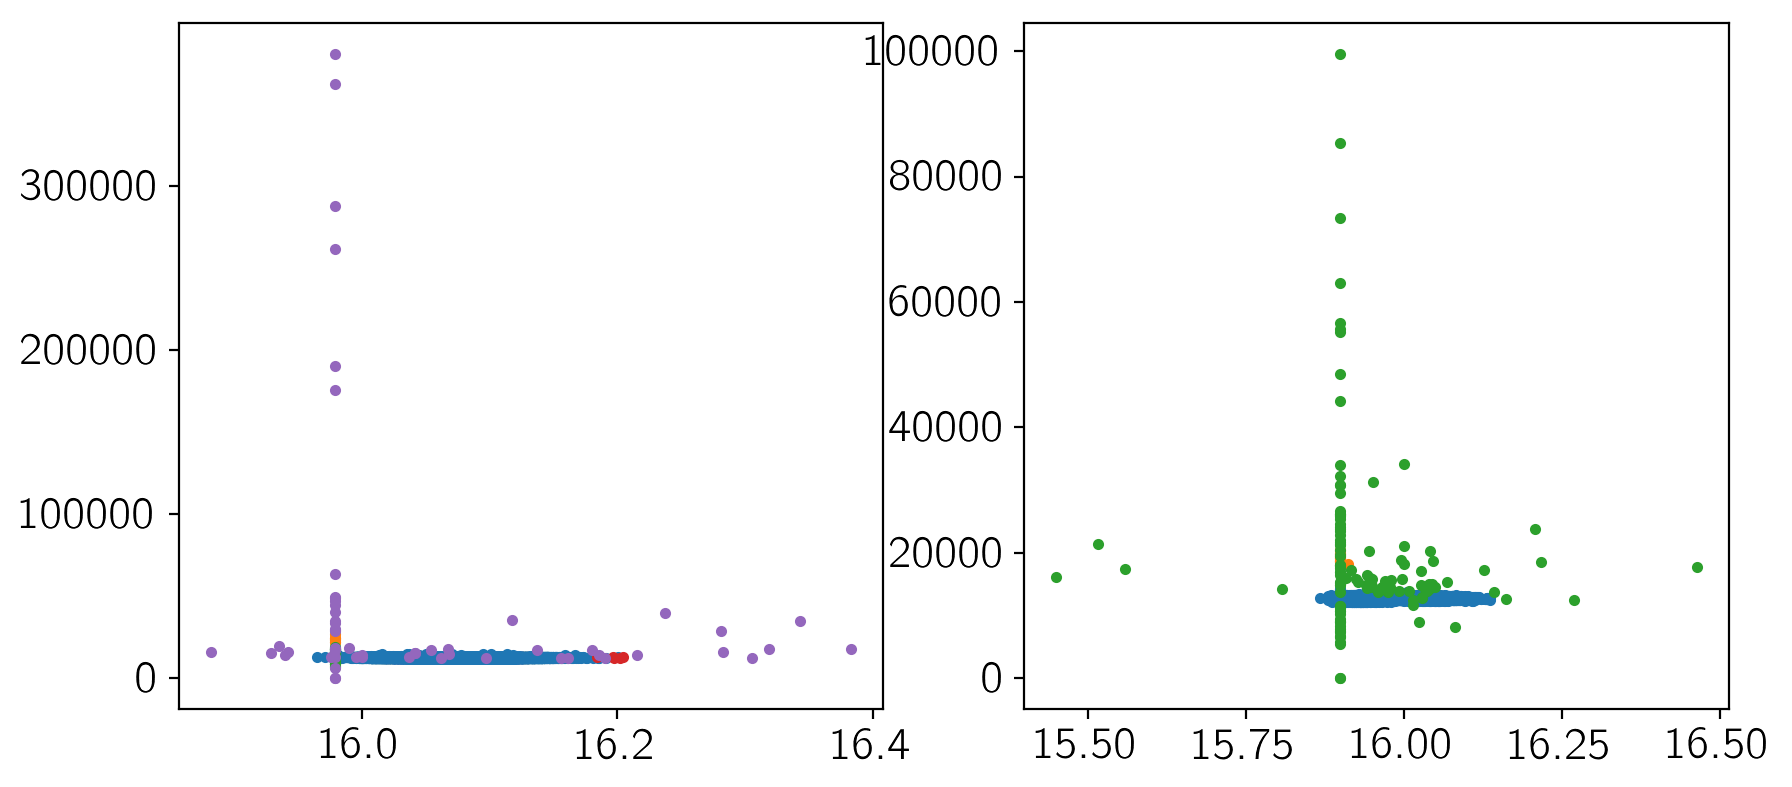

In [29]:
plt.figure(figsize=(10,10))

for i,((aorName, gFits), phots, dbsPred) in enumerate(zip(gaussianFits.items(), photsStack.values(), dbsPhotsPred.values())):
    
    yctrs  = gFits.T[y]#['ycenter']
    xctrs  = gFits.T[x]#['xcenter']
    
    dbs_options = set(dbsPred)
    
    print(aorName, sum(dbsPred != list(dbs_options)[0]), dbs_options)
    
    subplot = plt.subplot(len(gaussianFits), 2, i + 1)
    for dbsOpt in dbs_options:
        if i+1%2:
            subplot.plot(yctrs[dbsPred==dbsOpt],phots[dbsPred==dbsOpt],'.', alpha=1)
        else:
            plot(xctrs[dbsPred==dbsOpt],phots[dbsPred==dbsOpt],'.', alpha=1)

**Plot Photometry for Inliers (non-Outliers) only**

r61524480 103 {0, 1, -1}
r61524736 138 {0, 1, -1}


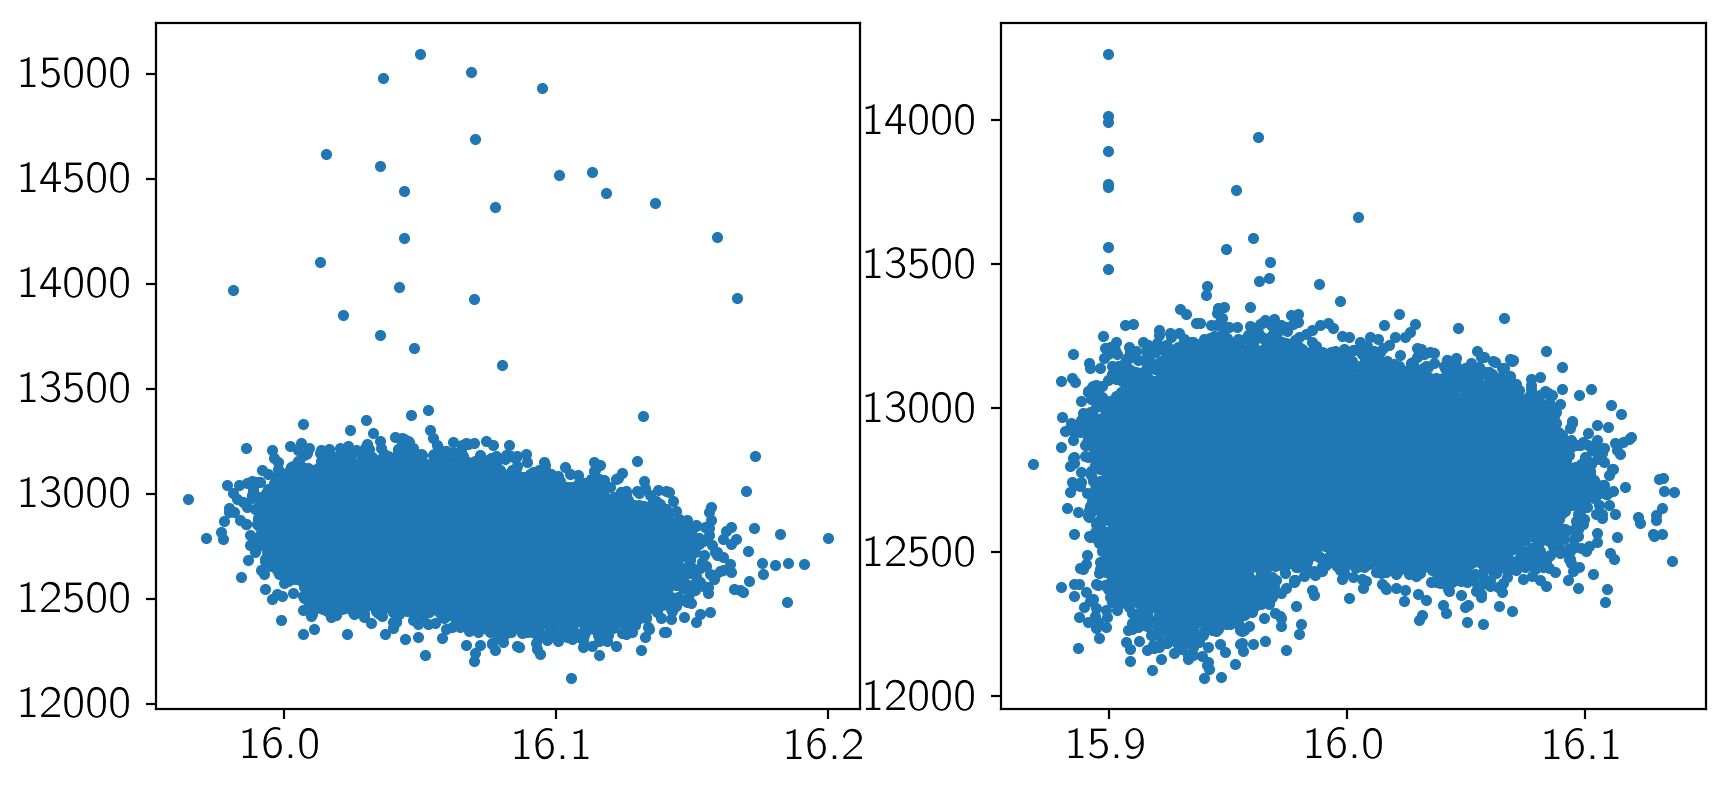

In [30]:
plt.figure(figsize=(10,10))

for i,((aorName, gFits), phots, useNow) in enumerate(zip(gaussianFits.items(), photsStack.values(), inliersPhots.values())):
    
    yctrs  = gFits.T[y]#['ycenter']
    xctrs  = gFits.T[x]#['xcenter']
    
    dbs_options = set(dbsPred)
    
    print(aorName, sum(phots.size - useNow.sum()), dbs_options)
    
    subplot = plt.subplot(len(gaussianFits), 2, i + 1)
    if i+1%2:
        subplot.plot(yctrs[useNow],phots[useNow],'.', alpha=1);
    else:
        plot(xctrs[useNow],phots[useNow],'.', alpha=1);

**Plot Full set of All Photometric Points, Both Before and After DBSCAN Outlier Rejection **

**Examine Binned Data for Correlation Visualization**

In [ ]:
nbins   = 120
nWide   = 2
zipStack = zip(nFrames.items(), photsStack.values(), gaussianFits.values())
for kframe, ((aorName, nFs), phots, gaussian_fits) in enumerate(zipStack):
    binsize      = nFs // nbins
    
    gcY           = gaussian_fits.T[y].copy()#['ycenter'].copy()
    gcX           = gaussian_fits.T[x].copy()#['xcenter'].copy()
    # phots         = phots[keep]
    
    Yc_argsort    = np.argsort(gcY)
    flux_sortedYc = phots[Yc_argsort].values
    gcY_sortedYc  = gcY[Yc_argsort]
    
    Xc_argsort    = np.argsort(gcX)
    flux_sortedXc = phots[Xc_argsort].values
    
    gcX_sortedXc  = gcX[Xc_argsort]
    
    bin_fluxY, bin_fluxY_err = bin_array(flux_sortedYc, uncs = None,  binsize=binsize, KeepTheChange = False)
    bin_fluxX, bin_fluxX_err = bin_array(flux_sortedXc, uncs = None,  binsize=binsize, KeepTheChange = False)
    bin_gcY, bin_gcYerr    = bin_array(gcY_sortedYc, uncs = None,  binsize=binsize, KeepTheChange = False)
    bin_gcX, bin_gcXerr    = bin_array(gcX_sortedXc, uncs = None,  binsize=binsize, KeepTheChange = False)
    
    plt.subplot(len(nFrames)//nWide, len(nFrames)//(len(nFrames)/nWide), kframe+1)
    plt.plot(bin_gcY-(median(gcY)), bin_fluxY,'o',alpha=0.5,mew=0);
    plt.plot(bin_gcX-(median(gcX)), bin_fluxX,'o',alpha=0.5,mew=0);
    
    plt.ylim(None, bin_fluxY.mean() + bin_fluxY.std())

** Plot Binned Y / X vs Flux Correlation**

# Identify Phase Coverage

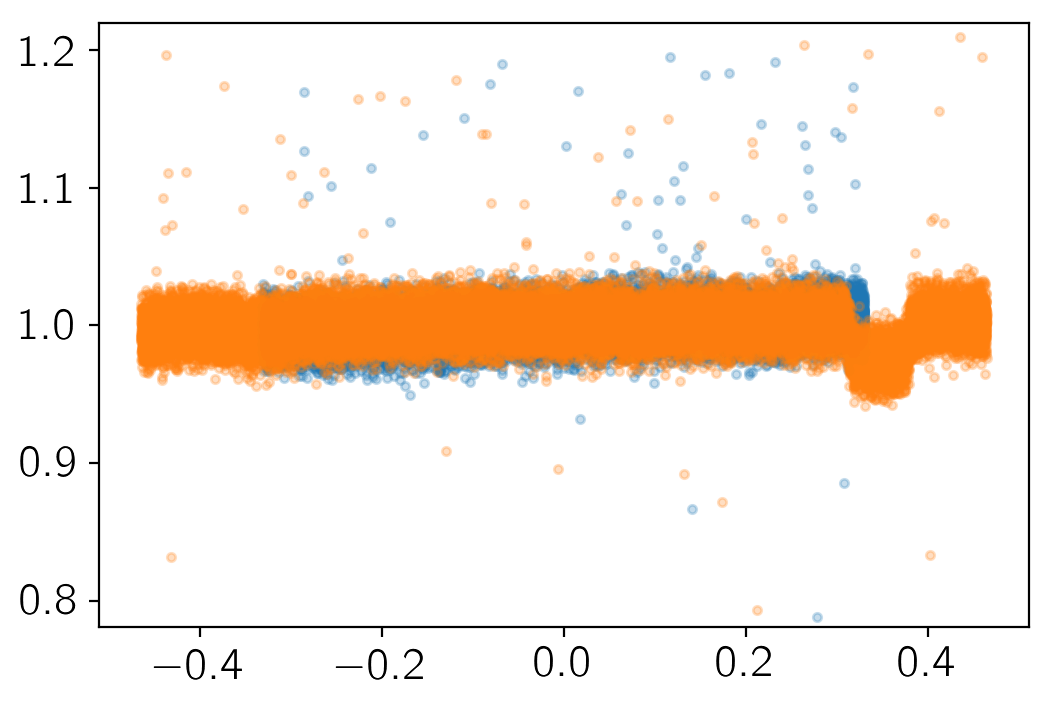

In [32]:
for times, phots in zip(timeCubeStack.values(), photsStack.values()):
    plt.plot(times-times.mean(), phots / np.median(phots),'.', alpha=0.25)
    plt.ylim(1.0 - 3*(phots / np.median(phots)).std(),1.0 + 3*(phots / np.median(phots)).std())

# Pixel Level Decorrelation

**Clip Outliers: DBSCAN PLD components in 1D to identify outliers**

In [33]:
PLDFeatureStack = {}

for aorNow in AORs:
    PLDFeatureStack[aorNow] = extract_PLD_components(imageCubeStack[aorNow], order=2).T

In [34]:
dbsPLD  = DBSCAN()#n_jobs=-1)
dbsPLDPred  = {}

dbsClean= 0

for i,(aorName, PLD_components) in tqdm_notebook(enumerate(PLDFeatureStack.items()), 
                                                 total=len(PLDFeatureStack),
                                                 desc='AORs'):
    
    dbsPLDPred[aorName] = []
    
    for PLDComp in tqdm_notebook(PLD_components.T, total=len(PLD_components.T), desc='PLDComp ' + str(i)):
        featuresNow = stdScaler.fit_transform(PLDComp[:,None])
        dbsPLDPred[aorName].append(dbsPLD.fit_predict(featuresNow))
    
    dbsPLDPred[aorName] = np.transpose(dbsPLDPred[aorName])

HBox(children=(IntProgress(value=0, description='AORs', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='PLDComp 0', max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, description='PLDComp 1', max=18), HTML(value='')))

In [35]:
inliersPLD = {}

for k,(aorName, dbsPLDNow) in enumerate(dbsPLDPred.items()):
    
    inliersPLD[aorName] = np.zeros(dbsPLDNow.shape, dtype=bool)
    
    for k, dbsPLDCompNow in enumerate(dbsPLDNow):
        inliersPLD[aorName][k]= dbsPLDCompNow == dbsClean

In [36]:
inliersPLD[aorName].shape

(39680, 18)

**Combine all Inlier Arrays to Create Master Inliers**

All of the photometry, time, centering, and PLD components need to have the same indexing and size.

In [37]:
inliersMaster = {}
for k, ((aorName, inliersPhot), inlierPLDNow)  in enumerate(zip(inliersPhots.items(), inliersPLD.values())):
    inliersMaster[aorName] = inliersPhot.copy()
    for inlierPLDComp in inlierPLDNow.T:
        inliersMaster[aorName] = inliersMaster[aorName] * inlierPLDComp

**Save After PLD Components' DBSCANs**

In [ ]:
save_pickle_dict = {'dataDir':dataDir, 
                    'AORNumberStack':AORNumberStack,
                    'timeCubeStack':timeCubeStack, 
                    'imageCubeStack':imageCubeStack, 
                    'noiseCubeStack':noiseCubeStack, 
                    'nFrames':nFrames, 
                    'nTimeSkips':nTimeSkips,
                    'median_backgrounds':median_backgrounds, 
                    # 'FWCStack':FWCStack, 
                    'gaussianFits':gaussianFits,
                    'PLDFeatureStack':PLDFeatureStack,
                    'photsStack':photsStack, 
                    'photsErrStack':photsErrStack,
                    'dbsPhotsPred':dbsPhotsPred,
                    'inliersPhots':inliersPhots,
                    'dbsPLDPred':dbsPLDPred,
                    'inliersPLD':inliersPLD,
                    'inliersMaster':inliersMaster
                    }

lastSavedFile = savePickleOut(save_pickle_dict, header=planetName, stacked=True)
print(lastSavedFile)

In [ ]:
# load_filename    = '../SaveFiles/SaveState/save_state_'+planetname+'_'+date_last_saved+'_Stacked_All_at_Once_FULL.pickle.save'
load_filename    = lastSavedFile
load_pickle_dict = joblib.load(load_filename)#loadPickle(load_filename)

**Fit Spiderman Model with PLD to 1st AOR**

In [205]:
aor_1, aor_0 = timeCubeStack.keys();

times_0 = timeCubeStack[aor_0][inliersMaster[aor_0]]
times_1 = timeCubeStack[aor_1][inliersMaster[aor_1]]

phots_0 = photsStack[aor_0][inliersMaster[aor_0]]
phots_1 = photsStack[aor_1][inliersMaster[aor_1]]

phots_0_err = np.sqrt(phots_0)
phots_1_err = np.sqrt(phots_1)

PLDfeatures_0 = PLDFeatureStack[aor_0][inliersMaster[aor_0]]
PLDfeatures_1 = PLDFeatureStack[aor_1][inliersMaster[aor_1]]

In [206]:
kPeriod   = iPeriod
kTCenter  = 57896.0283 #- 0.25 # -0.5
kEdepth   = 0.0029583
kTdepth   = (0.15967)**2.
kInc      = 90.0
# kBImpact  = 0.0
kAprs     = 6.47
# kRsAp     = 1.0 / kAprs

k_u1      = 0.1
k_u2      = 0.2

k_pc_a    = 0.0015495
k_pc_t0   = 0.03432
k_pc_per  = iPeriod

k_slope   = 0.0011371
k_ln_t0   = 57896.0 # + 0.5 # -0.5

k_amp     = 0.0015495
k_shift   = 0.03432

fTCenter = iTCenter - 0.01

In [207]:
init_eclipse_params = batman.TransitParams()

init_eclipse_params.per         = kPeriod
init_eclipse_params.t0          = fTCenter
init_eclipse_params.inc         = iInc
init_eclipse_params.a           = kAprs
init_eclipse_params.fp          = kEdepth
init_eclipse_params.rp          = sqrt(kTdepth)
init_eclipse_params.ecc         = iEcc
init_eclipse_params.w           = iOmega

init_eclipse_params.t_secondary = fTCenter + iPeriod * 0.5
init_eclipse_params.limb_dark   = 'uniform'
init_eclipse_params.u           = []
init_1st_eclipse_model          = batman.TransitModel(init_eclipse_params, times_0, transittype="secondary")
init_1st_eclipse_lightcurve     = init_1st_eclipse_model.light_curve(init_eclipse_params)

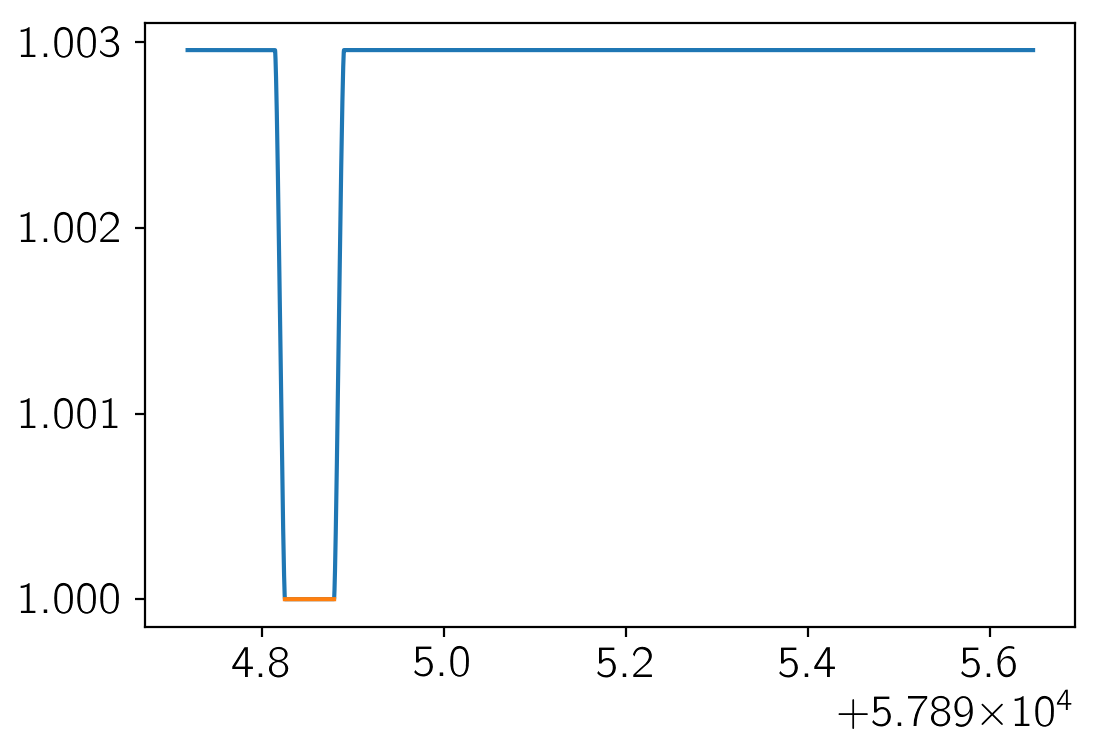

In [208]:
in_1st_eclipse = init_1st_eclipse_lightcurve == 1

plot(times_0,init_1st_eclipse_lightcurve);
plot(times_0[in_1st_eclipse], init_1st_eclipse_lightcurve[in_1st_eclipse]);

# nEpochs = 1698
# axvline(init_eclipse_params.t_secondary + nEpochs*iPeriod,c='orange');

In [209]:
med_eclipse_1 = median(phots_0[in_1st_eclipse == 1.0])

In [210]:
initialParams_1st_halfSpider_PhaseCurve = Parameters()

initialParams_1st_halfSpider_PhaseCurve.add_many(
    # Planetary Parameters
    ('period' , kPeriod , False),
    ('tCenter', fTCenter, True , fTCenter-0.01, fTCenter+0.01),
    ('inc'    , kInc    , True , 0   , 90.0 ),
    ('aprs'   , kAprs   , True , 0.0 , 100.0 ),
    ('edepth' , kEdepth , False, 0.0 , 1.0 ),
    ('tdepth' , kTdepth , True , 0.0 , 1.0 ),
    ('ecc'    , iEcc    , False, 0.0 , 1.0 ),
    ('omega'  , iOmega  , False, 0.0 , 360.),
    ('u1'     , k_u1    , True , 0.0 , 1.0),
    ('u2'     , k_u2    , True , 0.0 , 1.0),
    ('xi'     , 0.0     , True , 0.0 , inf),
    ('T_night', 1000.0  , True , 0.0 , inf),
    ('delta_T', 500.0   , True , 0.0 , inf),
    
    # PLD Coefficients for the 0th AOR - Linear
    ('pld1_l' , 0.0     , True  ),
    ('pld2_l' , 0.0     , True  ),
    ('pld3_l' , 0.0     , True  ),
    ('pld4_l' , 0.0     , True  ),
    ('pld5_l' , 0.0     , True  ),
    ('pld6_l' , 0.0     , True  ),
    ('pld7_l' , 0.0     , True  ),
    ('pld8_l' , 0.0     , True  ),
    ('pld9_l' , 0.0     , True  ),
    
    # PLD Coefficients for the 0th AOR - Quadratic
    ('pld1_q' , 0.0     , True  ),
    ('pld2_q' , 0.0     , True  ),
    ('pld3_q' , 0.0     , True  ),
    ('pld4_q' , 0.0     , True  ),
    ('pld5_q' , 0.0     , True  ),
    ('pld6_q' , 0.0     , True  ),
    ('pld7_q' , 0.0     , True  ),
    ('pld8_q' , 0.0     , True  ),
    ('pld9_q' , 0.0     , True  ),
    
    # Out of transit linear baselines
    ('intcpt' , 1.0     , True),
    ('slope'  , 0.0     , True),
    ('crvtur' , 0.0     , False))

In [211]:
spider_params_example                = sp.ModelParams(brightness_model='zhang')
spider_params_example.n_layers       = 20
spider_params_example.stellar_radius = stellar_radius
spider_params_example.T_s            = stellar_temp
spider_params_example.l1             = 4.0 # Spitzer IRAC-2
spider_params_example.l2             = 5.0 # Spitzer IRAC-2

planet_a_au  = iApRs * stellar_radius * R_sun.value / au.value

spider_params_example.t0      = fTCenter       # Central time of PRIMARY transit [days]
spider_params_example.per     = iPeriod        # Period [days]
spider_params_example.a_abs   = planet_a_au   # The absolute value of the semi-major axis [AU]
spider_params_example.inc     = iInc          # orbital inclination (in degrees)
spider_params_example.ecc     = iEcc          # Eccentricity
spider_params_example.w       = iOmega        # Argument of periastron
spider_params_example.rp      = sqrt(iTdepth) # planet radius (in units of stellar radii)
spider_params_example.a       = iApRs         # Semi-major axis scaled by stellar radius
spider_params_example.p_u1    = k_u1          # Planetary limb darkening parameter
spider_params_example.p_u2    = k_u2          # Planetary limb darkening parameter

spider_params_example.xi      = 0.0           # Ratio of radiative to advective timescale             
spider_params_example.T_n     = 1000.0        # Temperature of nightside
spider_params_example.delta_T = 500.0         # Day-night temperature contrast

In [212]:
lc_1st_halfSpider_PhaseCurve = Model(spiderman_half_phase_curve_lmfit_model, 
                                      independent_vars = ['times', 'PLDFeatures'])

In [213]:
spider_params       = spider_params_example

start = time()
fitResults_1st_halfSpider_PhaseCurve = lc_1st_halfSpider_PhaseCurve.fit(data= phots_0 / med_eclipse_1,
                                                                params      = initialParams_1st_halfSpider_PhaseCurve,
                                                                method      = 'leastsq',
                                                                weights     = 1 / phots_0_err,
                                                                times       = times_0, 
                                                                PLDFeatures = PLDfeatures_0
                                                                )

print("Full phase curve fitting operation took {} seconds".format(time()-start))

Full phase curve fitting operation took 326.5442728996277 seconds


/Users/jonathan/Research/Planets/Qatar2/analysis/spitzer_helper_functions.py:307: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  binArr  = mean(useArr.reshape(nCols, nRows),axis=1)
/Users/jonathan/Research/Planets/Qatar2/analysis/spitzer_helper_functions.py:308: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  stdArr  = std(useArr.reshape(nCols, nRows),axis=1) / sqrt(nSize)


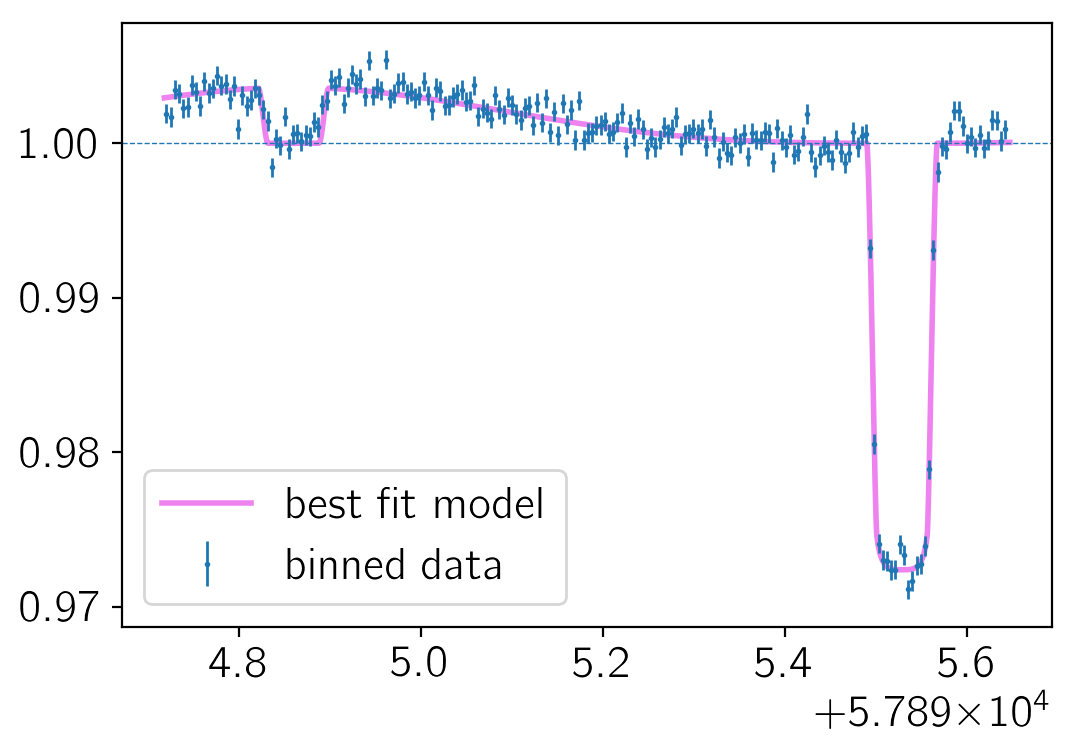

In [504]:
plot_model_over_reduced_lc_half_spider_PLDsq(times_0, PLDfeatures_0, fitResults_1st_halfSpider_PhaseCurve)
plt.axhline(1.0, ls='--', lw=0.5)

In [215]:
fitResults_1st_halfSpider_PhaseCurve.best_values

{'T_night': 0.52696485062482523,
 'aprs': 6.4392673634082183,
 'crvtur': 0.0,
 'delta_T': 994.10375114732688,
 'ecc': 0.0,
 'edepth': 0.0029583,
 'inc': 90.0,
 'intcpt': -114.55481889731593,
 'omega': 1.5707963267948966,
 'period': 1.3371182,
 'pld1_l': 115.78686314589095,
 'pld1_q': -54.86688297404978,
 'pld2_l': 116.17575806665225,
 'pld2_q': -11.272652560381974,
 'pld3_l': 116.63648436343094,
 'pld3_q': -15.392438246791768,
 'pld4_l': 116.40834531292339,
 'pld4_q': -35.237471293062384,
 'pld5_l': 115.38595467358681,
 'pld5_q': 0.33636819288625497,
 'pld6_l': 115.90028149351627,
 'pld6_q': -1.99758928961645,
 'pld7_l': 116.17805765560458,
 'pld7_q': -9.1269502394285045,
 'pld8_l': 115.1829847964312,
 'pld8_q': 0.49699256118164875,
 'pld9_l': 115.68445179039149,
 'pld9_q': -0.18119159545133498,
 'slope': 0.0017300710075374745,
 'tCenter': 55623.764534277951,
 'tdepth': 0.026101875119245332,
 'u1': 2.5790431122663104e-05,
 'u2': 0.32385237527440169,
 'xi': 0.0}

In [216]:
fitResults_1st_halfSpider_PhaseCurve.best_values['tCenter'] - initialParams_1st_halfSpider_PhaseCurve['tCenter']

0.0077442781621357426

**Fit Spiderman Model with PLD to 2nd AOR**

In [262]:
aor_1, aor_0 = timeCubeStack.keys();

times_0 = timeCubeStack[aor_0][inliersMaster[aor_0]]
times_1 = timeCubeStack[aor_1][inliersMaster[aor_1]]

times_c = np.c_[[times_0], [times_1]].flatten()

phots_0 = photsStack[aor_0][inliersMaster[aor_0]]
phots_1 = photsStack[aor_1][inliersMaster[aor_1]]

phots_0_err = np.sqrt(phots_0)
phots_1_err = np.sqrt(phots_1)

PLDfeatures_0 = PLDFeatureStack[aor_0][inliersMaster[aor_0]]
PLDfeatures_1 = PLDFeatureStack[aor_1][inliersMaster[aor_1]]

In [263]:
fit1_res = fitResults_1st_halfSpider_PhaseCurve.best_values

initialParams_2nd_halfSpider_PhaseCurve = Parameters()

initialParams_2nd_halfSpider_PhaseCurve.add_many(
    # Planetary Parameters
    ('period' , fit1_res['period'] , False),
    ('tCenter', fit1_res['tCenter'], False, fTCenter-0.01, fTCenter+0.01),
    ('inc'    , fit1_res['inc']    , False, 0   , 90.0 ),
    ('aprs'   , fit1_res['aprs']   , False, 0.0 , 100.0 ),
    ('edepth' , fit1_res['edepth'] , False, 0.0 , 1.0 ),
    ('tdepth' , fit1_res['tdepth'] , False, 0.0 , 1.0 ),
    ('ecc'    , fit1_res['ecc']    , False, 0.0 , 1.0 ),
    ('omega'  , fit1_res['omega']  , False, 0.0 , 360.),
    ('u1'     , fit1_res['u1']     , False, 0.0 , 1.0),
    ('u2'     , fit1_res['u2']     , False, 0.0 , 1.0),
    ('xi'     , fit1_res['xi']     , False, 0.0 , inf),
    ('T_night', fit1_res['T_night'], False, 0.0 , inf),
    ('delta_T', fit1_res['delta_T'], False, 0.0 , inf),
    
    # PLD Coefficients for the 0th AOR - Linear
    ('pld1_l' , 0.0     , True  ),
    ('pld2_l' , 0.0     , True  ),
    ('pld3_l' , 0.0     , True  ),
    ('pld4_l' , 0.0     , True  ),
    ('pld5_l' , 0.0     , True  ),
    ('pld6_l' , 0.0     , True  ),
    ('pld7_l' , 0.0     , True  ),
    ('pld8_l' , 0.0     , True  ),
    ('pld9_l' , 0.0     , True  ),
    
    # PLD Coefficients for the 0th AOR - Quadratic
    ('pld1_q' , 0.0     , True  ),
    ('pld2_q' , 0.0     , True  ),
    ('pld3_q' , 0.0     , True  ),
    ('pld4_q' , 0.0     , True  ),
    ('pld5_q' , 0.0     , True  ),
    ('pld6_q' , 0.0     , True  ),
    ('pld7_q' , 0.0     , True  ),
    ('pld8_q' , 0.0     , True  ),
    ('pld9_q' , 0.0     , True  ),
    
    # Out of transit linear baselines
    ('intcpt' , fit1_res['intcpt'], False),
    ('slope'  , fit1_res['slope'] , False),
    ('crvtur' , fit1_res['crvtur'], False))

In [264]:
spider_params_example                = sp.ModelParams(brightness_model='zhang')
spider_params_example.n_layers       = 20
spider_params_example.stellar_radius = stellar_radius
spider_params_example.T_s            = stellar_temp
spider_params_example.l1             = 4.0 # Spitzer IRAC-2
spider_params_example.l2             = 5.0 # Spitzer IRAC-2

planet_a_au  = iApRs * stellar_radius * R_sun.value / au.value

spider_params_example.t0      = fit1_res['tCenter'] # Central time of PRIMARY transit [days]
spider_params_example.per     = iPeriod      # Period [days]
spider_params_example.a_abs   = planet_a_au  # The absolute value of the semi-major axis [AU]
spider_params_example.inc     = fit1_res['inc'] # orbital inclination (in degrees)
spider_params_example.ecc     = iEcc         # Eccentricity
spider_params_example.w       = iOmega       # Argument of periastron
spider_params_example.rp      = sqrt(fit1_res['tdepth']) # planet radius (in units of stellar radii)
spider_params_example.a       = fit1_res['aprs'] # Semi-major axis scaled by stellar radius
spider_params_example.p_u1    = fit1_res['u1'] # Planetary limb darkening parameter
spider_params_example.p_u2    = fit1_res['u2'] # Planetary limb darkening parameter

spider_params_example.xi      = fit1_res['xi']      # Ratio of radiative to advective timescale             
spider_params_example.T_n     = fit1_res['T_night'] # Temperature of nightside
spider_params_example.delta_T = fit1_res['delta_T'] # Day-night temperature contrast

In [265]:
lc_2nd_halfSpider_PhaseCurve = Model(spiderman_half_phase_curve_lmfit_model, 
                                     independent_vars = ['times', 'PLDFeatures'])

In [266]:
spider_params       = spider_params_example

In [267]:
start = time()
fitResults_2nd_halfSpider_PhaseCurve = lc_2nd_halfSpider_PhaseCurve.fit(data        = phots_1 / med_eclipse_2,
                                                                params      = initialParams_2nd_halfSpider_PhaseCurve,
                                                                method      = 'leastsq',
                                                                weights     = 1 / phots_1_err,
                                                                times       = times_1, 
                                                                PLDFeatures = PLDfeatures_1
                                                                )

print("Full phase curve fitting operation took {} seconds".format(time()-start))

Full phase curve fitting operation took 12.409294843673706 seconds


/Users/jonathan/Research/Planets/Qatar2/analysis/spitzer_helper_functions.py:307: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  binArr  = mean(useArr.reshape(nCols, nRows),axis=1)
/Users/jonathan/Research/Planets/Qatar2/analysis/spitzer_helper_functions.py:308: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  stdArr  = std(useArr.reshape(nCols, nRows),axis=1) / sqrt(nSize)


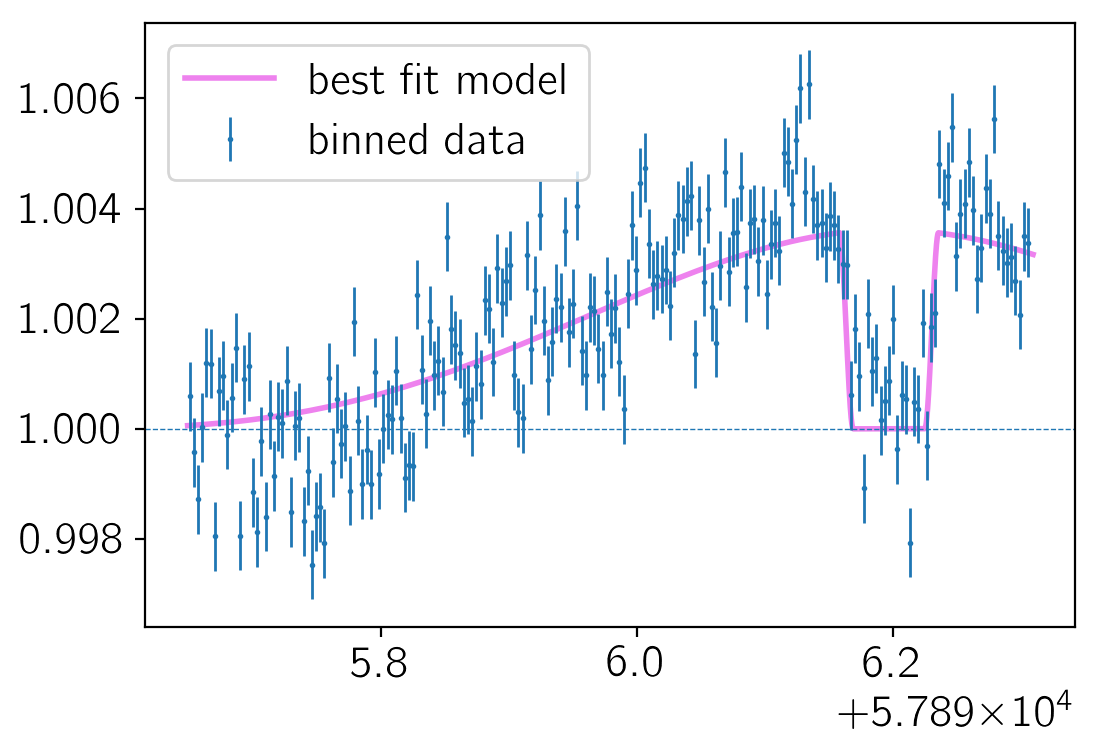

In [268]:
plot_model_over_reduced_lc_half_spider_PLDsq(times_1.values(), PLDfeatures_1, fitResults_2nd_halfSpider_PhaseCurve)
plt.axhline(1.0, ls='--', lw=0.5)

In [269]:
fitResults_2nd_halfSpider_PhaseCurve.best_values

{'T_night': 0.52696485062482523,
 'aprs': 6.4392673634082183,
 'crvtur': 0.0,
 'delta_T': 994.10375114732688,
 'ecc': 0.0,
 'edepth': 0.0029583,
 'inc': 90.0,
 'intcpt': -114.55481889731593,
 'omega': 1.5707963267948966,
 'period': 1.3371182,
 'pld1_l': 115.87578855581906,
 'pld1_q': -56.020977089378455,
 'pld2_l': 116.12930074805547,
 'pld2_q': -2.79704143188038,
 'pld3_l': 116.23680661872355,
 'pld3_q': -1.5323347200153297,
 'pld4_l': 116.5119008040833,
 'pld4_q': -34.804478006086462,
 'pld5_l': 116.22841953185207,
 'pld5_q': -7.5821947101009144,
 'pld6_l': 116.57633753528729,
 'pld6_q': -5.0725687184583892,
 'pld7_l': 116.80638284900337,
 'pld7_q': -17.243432193836046,
 'pld8_l': 115.89740794453255,
 'pld8_q': -0.62190534676645282,
 'pld9_l': 114.86964923385791,
 'pld9_q': 0.71087495500434617,
 'slope': 0.0017300710075374745,
 'tCenter': 55623.764534277951,
 'tdepth': 0.026101875119245332,
 'u1': 2.5790431122663104e-05,
 'u2': 0.32385237527440169,
 'xi': 0.0}

In [272]:
fitResults_2nd_halfSpider_PhaseCurve.best_values['tCenter'] - initialParams_2nd_halfSpider_PhaseCurve['tCenter']

0.0

**Fit Spiderman Model with PLD to Both AORs**

In [483]:
aor_1, aor_0 = timeCubeStack.keys();

times_0 = timeCubeStack[aor_0][inliersMaster[aor_0]]
times_1 = timeCubeStack[aor_1][inliersMaster[aor_1]]

times_c = np.c_[[times_0], [times_1]].flatten()

phots_0 = photsStack[aor_0][inliersMaster[aor_0]].values
phots_1 = photsStack[aor_1][inliersMaster[aor_1]].values

phots_0_err = np.sqrt(phots_0)
phots_1_err = np.sqrt(phots_1)

PLDfeatures_0 = PLDFeatureStack[aor_0][inliersMaster[aor_0]]
PLDfeatures_1 = PLDFeatureStack[aor_1][inliersMaster[aor_1]]

In [539]:
fit1_res = fitResults_1st_halfSpider_PhaseCurve.best_values
fit2_res = fitResults_2nd_halfSpider_PhaseCurve.best_values

fit_bimpact = 0.0 #inc2b(fit1_res['inc']*pi/180, fit1_res['aprs']) # 90 deg = 0.0 impact

initialParams_Full_Spider_PhaseCurve = Parameters()

initialParams_Full_Spider_PhaseCurve.add_many(
    # Planetary Parameters
    ('period' , fit1_res['period'] , False),
    ('tCenter', fit1_res['tCenter'], True , fTCenter-0.01, fTCenter+0.01),
    # ('bImpact', fit_bimpact        , False),#, 0   , 90.0 ),
    ('inc'    , fit1_res['inc']    , False, 0   , 90.0 ),
    ('aprs'   , fit1_res['aprs']   , True , 0.0 , 100.0 ),
    ('edepth' , fit1_res['edepth'] , False, 0.0 , 1.0 ),
    ('tdepth' , fit1_res['tdepth'] , True , 0.0 , 1.0 ),
    ('ecc'    , fit1_res['ecc']    , False, 0.0 , 1.0 ),
    ('omega'  , fit1_res['omega']  , False, 0.0 , 360.),
    ('u1'     , fit1_res['u1']     , True , 0.0 , 1.0),
    ('u2'     , fit1_res['u2']     , True , 0.0 , 1.0),
    ('xi'     , 1e-6     , True , 0.0 , inf), # fit1_res['xi']
    ('T_night', fit1_res['T_night'], True , 0.0 , inf),
    ('delta_T', fit1_res['delta_T'], True , 0.0 , inf),
    
    # PLD Coefficients for the 0th AOR - Linear
    ('pld1_l_1' , fit1_res['pld1_l'], True  ),
    ('pld2_l_1' , fit1_res['pld2_l'], True  ),
    ('pld3_l_1' , fit1_res['pld3_l'], True  ),
    ('pld4_l_1' , fit1_res['pld4_l'], True  ),
    ('pld5_l_1' , fit1_res['pld5_l'], True  ),
    ('pld6_l_1' , fit1_res['pld6_l'], True  ),
    ('pld7_l_1' , fit1_res['pld7_l'], True  ),
    ('pld8_l_1' , fit1_res['pld8_l'], True  ),
    ('pld9_l_1' , fit1_res['pld9_l'], True  ),
    
    # PLD Coefficients for the 0th AOR - Quadratic
    ('pld1_q_1' , fit1_res['pld1_q'], True  ),
    ('pld2_q_1' , fit1_res['pld2_q'], True  ),
    ('pld3_q_1' , fit1_res['pld3_q'], True  ),
    ('pld4_q_1' , fit1_res['pld4_q'], True  ),
    ('pld5_q_1' , fit1_res['pld5_q'], True  ),
    ('pld6_q_1' , fit1_res['pld6_q'], True  ),
    ('pld7_q_1' , fit1_res['pld7_q'], True  ),
    ('pld8_q_1' , fit1_res['pld8_q'], True  ),
    ('pld9_q_1' , fit1_res['pld9_q'], True  ),
    
    # PLD Coefficients for the 0th AOR - Linear
    ('pld1_l_2' , fit2_res['pld1_l'], True  ),
    ('pld2_l_2' , fit2_res['pld2_l'], True  ),
    ('pld3_l_2' , fit2_res['pld3_l'], True  ),
    ('pld4_l_2' , fit2_res['pld4_l'], True  ),
    ('pld5_l_2' , fit2_res['pld5_l'], True  ),
    ('pld6_l_2' , fit2_res['pld6_l'], True  ),
    ('pld7_l_2' , fit2_res['pld7_l'], True  ),
    ('pld8_l_2' , fit2_res['pld8_l'], True  ),
    ('pld9_l_2' , fit2_res['pld9_l'], True  ),
    
    # PLD Coefficients for the 0th AOR - Quadratic
    ('pld1_q_2' , fit2_res['pld1_q'], True  ),
    ('pld2_q_2' , fit2_res['pld2_q'], True  ),
    ('pld3_q_2' , fit2_res['pld3_q'], True  ),
    ('pld4_q_2' , fit2_res['pld4_q'], True  ),
    ('pld5_q_2' , fit2_res['pld5_q'], True  ),
    ('pld6_q_2' , fit2_res['pld6_q'], True  ),
    ('pld7_q_2' , fit2_res['pld7_q'], True  ),
    ('pld8_q_2' , fit2_res['pld8_q'], True  ),
    ('pld9_q_2' , fit2_res['pld9_q'], True  ),
    
    # Out of transit linear baselines
    ('intcpt' , fit1_res['intcpt'], True ),
    ('slope'  , fit1_res['slope'] , True ),
    ('crvtur' , fit1_res['crvtur'], False))

In [540]:
spider_params_example                = sp.ModelParams(brightness_model='zhang')
spider_params_example.n_layers       = 20
spider_params_example.stellar_radius = stellar_radius
spider_params_example.T_s            = stellar_temp
spider_params_example.l1             = 4.0 # Spitzer IRAC-2
spider_params_example.l2             = 5.0 # Spitzer IRAC-2

planet_a_au  = iApRs * stellar_radius * R_sun.value / au.value

spider_params_example.t0      = fit1_res['tCenter'] # Central time of PRIMARY transit [days]
spider_params_example.per     = iPeriod      # Period [days]
spider_params_example.a_abs   = planet_a_au  # The absolute value of the semi-major axis [AU]
spider_params_example.inc     = fit1_res['inc'] # orbital inclination (in degrees)
spider_params_example.ecc     = iEcc         # Eccentricity
spider_params_example.w       = iOmega       # Argument of periastron
spider_params_example.rp      = sqrt(fit1_res['tdepth']) # planet radius (in units of stellar radii)
spider_params_example.a       = fit1_res['aprs'] # Semi-major axis scaled by stellar radius
spider_params_example.p_u1    = fit1_res['u1'] # Planetary limb darkening parameter
spider_params_example.p_u2    = fit1_res['u2'] # Planetary limb darkening parameter

spider_params_example.xi      = fit1_res['xi']      # Ratio of radiative to advective timescale             
spider_params_example.T_n     = fit1_res['T_night'] # Temperature of nightside
spider_params_example.delta_T = fit1_res['delta_T'] # Day-night temperature contrast

In [541]:
lc_Full_halfSpider_PhaseCurve = Model(spiderman_full_phase_curve_lmfit_model, 
                                     independent_vars = ['times_0', 'times_1', 'PLDFeatures_0', 'PLDFeatures_1'])

In [542]:
spider_params = spider_params_example

phots_c       = np.c_[[phots_0 / med_eclipse_1], [phots_1 / med_eclipse_2]].flatten()
phots_c_err   = np.c_[[phots_0_err / med_eclipse_1], [phots_1_err / med_eclipse_2]].flatten()

In [543]:
start = time()
fitResults_Full_halfSpider_PhaseCurve = lc_Full_halfSpider_PhaseCurve.fit(data= phots_c,
                                                            params        = initialParams_Full_Spider_PhaseCurve,
                                                            method        = 'leastsq',
                                                            weights       = 1 / phots_c_err,
                                                            times_0       = times_0, 
                                                            times_1       = times_1, 
                                                            PLDFeatures_0 = PLDfeatures_0,
                                                            PLDFeatures_1 = PLDfeatures_1
                                                            )

print("Full phase curve fitting operation took {} seconds".format(time()-start))

Full phase curve fitting operation took 174.6251208782196 seconds


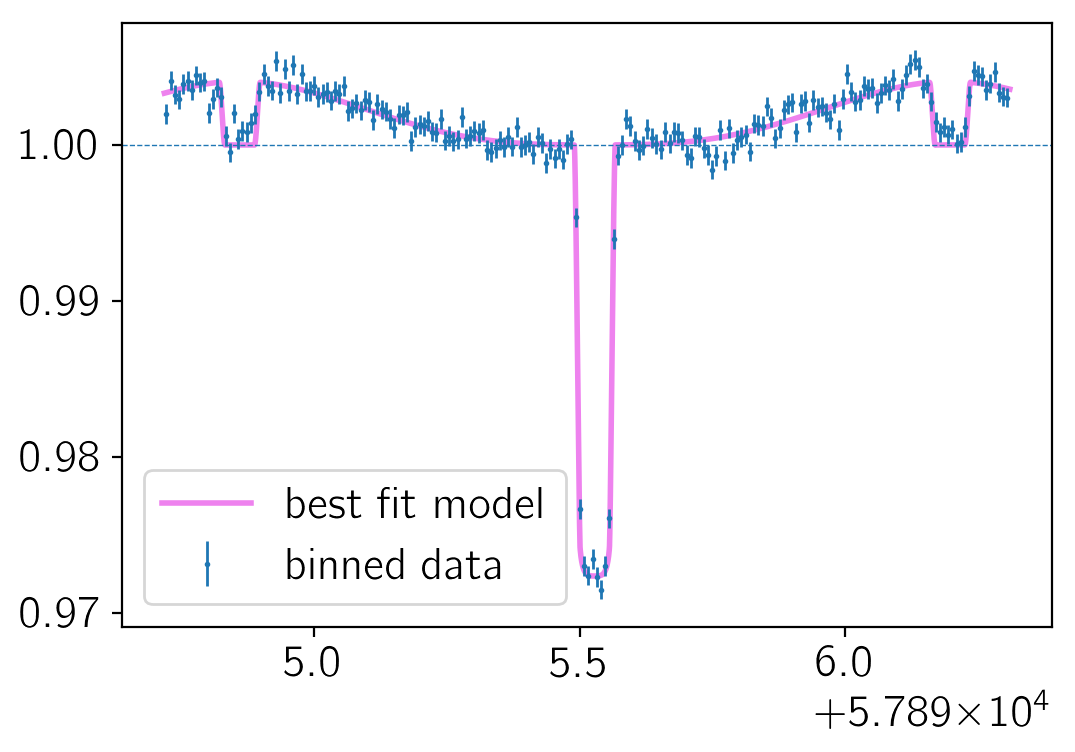

In [544]:
plot_model_over_reduced_full_lc_spider_PLDsq(times_0, times_1, PLDfeatures_0, PLDfeatures_1, 
                                             fitResults_Full_halfSpider_PhaseCurve, nbins=200)
plt.axhline(1.0, ls='--', lw=0.5)

In [545]:
fitResults_Full_halfSpider_PhaseCurve.best_values

{'T_night': 0.71390269189806843,
 'aprs': 6.4658260814377035,
 'crvtur': 0.0,
 'delta_T': 1098.9657218560114,
 'ecc': 0.0,
 'edepth': 0.0029583,
 'inc': 90.0,
 'intcpt': -114.55480565274441,
 'omega': 1.5707963267948966,
 'period': 1.3371182,
 'pld1_l_1': 115.7974031852995,
 'pld1_l_2': 115.87183355503915,
 'pld1_q_1': -54.721746344807158,
 'pld1_q_2': -53.529429240718663,
 'pld2_l_1': 116.17402091605513,
 'pld2_l_2': 116.11889123327633,
 'pld2_q_1': -11.386877031055549,
 'pld2_q_2': -3.5580052183009241,
 'pld3_l_1': 116.63633388672427,
 'pld3_l_2': 116.22887932032532,
 'pld3_q_1': -15.42917063947908,
 'pld3_q_2': -1.988486456843001,
 'pld4_l_1': 116.41289547550522,
 'pld4_l_2': 116.50495581926558,
 'pld4_q_1': -35.498984644272518,
 'pld4_q_2': -34.579128971212732,
 'pld5_l_1': 115.38744034538043,
 'pld5_l_2': 116.22750866846505,
 'pld5_q_1': 0.358460882784924,
 'pld5_q_2': -7.5766200694894721,
 'pld6_l_1': 115.90097445716653,
 'pld6_l_2': 116.57541244272383,
 'pld6_q_1': -1.9927106523

In [546]:
print(fitResults_Full_halfSpider_PhaseCurve.fit_report())

[[Model]]
    Model(spiderman_full_phase_curve_lmfit_model)
[[Fit Statistics]]
    # function evals   = 908
    # data points      = 67629
    # variables        = 46
    chi-square         = 103995.170
    reduced chi-square = 1.539
    Akaike info crit   = 29193.271
    Bayesian info crit = 29612.873
[[Variables]]
    period:     1.337118 (fixed)
    tCenter:    55623.7645 +/- 0        (0.00%) (init= 55623.76)
    inc:        90 (fixed)
    aprs:       6.46582608 +/- 0        (0.00%) (init= 6.439267)
    edepth:     0.0029583 (fixed)
    tdepth:     0.02644994 +/- 0        (0.00%) (init= 0.02610188)
    ecc:        0 (fixed)
    omega:      1.570796 (fixed)
    u1:         7.2720e-15 +/- 0        (0.00%) (init= 2.579043e-05)
    u2:         0.25677164 +/- 0        (0.00%) (init= 0.3238524)
    xi:         1.0000e-06 +/- 0        (0.00%) (init= 1e-06)
    T_night:    0.71390269 +/- 0        (0.00%) (init= 0.5269649)
    delta_T:    1098.96572 +/- 0        (0.00%) (init= 994.1038)
    